In [9]:
%%time
# Data manipulation
import numpy as np
import pandas as pd

# Creating training and test sets
import sklearn

# File system management
import os.path

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

#training/test split
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, ShuffleSplit

# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# here we can change some of the parameters interactively
from ipywidgets import widgets as wd
from sklearn.model_selection import cross_val_score, cross_validate

#for weights standardization
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from matplotlib import pyplot as plt

# Support vector machines
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

Wall time: 0 ns


In [11]:
%%time
# Constants
#DATAPATH_BASE = 'https://machinelearningi.blob.core.windows.net/group-project/'
#DATAPATH_SAS_TOKEN = '?sv=2019-02-02&ss=bfqt&srt=sco&sp=rwdlacup&se=2020-04-27T11:12:37Z&st=2020-01-23T04:12:37Z&spr=https&sig=jpIpjrp8dIg9eyUyPpmgTe5yj9i1ZoCSru5kBVHcUO8%3D'
#DATAPATH_FILENAME = 'Arrest_Data_from_2010_to_Present.csv'
#DATAPATH_SMALL_FILENAME = 'Arrest_Data_from_2010_to_Present_Small.csv'

# Fully qualified paths ready to use
#DATA_SOURCE = "".join([DATAPATH_BASE, DATAPATH_FILENAME, DATAPATH_SAS_TOKEN])

# Options
#pd.set_option('float_format', '{:.2f}'.format)  # Reign in the scientific notation for reasonable values

# Load data for analysis; only read if needed because the import can take a long time
#try:
#    if len(df.index) < 1:
#        df_raw = pd.read_csv(DATA_SOURCE) # If we get here, the dataframe was empty
#except:   
#    df_raw = pd.read_csv(DATA_SOURCE) # If we get here, the dataframe did not exist

df_raw = pd.read_csv("Arrest_Data_From_2010_to_Present.csv")

df = df_raw

print("The dataset has {:,} rows and {:,} columns".format(*df.shape))
    

The dataset has 1,324,973 rows and 17 columns
Wall time: 3.04 s


In [12]:
%%time
# Time - filter out 0 and missing
df = df[df['Time'] != 0]
df['Time'] = df['Time'].astype(str) 
df = df[df['Time'] != 'nan']

# Time - Convert float to string. Get rid of decimals. Replace missing or invalid values with '0000'.
df['Time'] = df['Time'].astype(str).str.split(".", expand = True)[0].replace(to_replace = ['2400','nan'], value = '0000') 

# Time - Fill time column with leading zeros to have 4 characters total
df['Time'] = df['Time'].apply(lambda x: '{0:0>4}'.format(x))

# Time - Add colon to Time values by converting attribute to a datetime variable 
df['Time'] = pd.to_datetime(df['Time'], format = '%H%M').dt.time

# Age - Drop the observations where Age is less than 16
df.drop(df[df['Age'] < 16].index, inplace = True) 

# Arrest Type Code - Drop the observations where Arrest Type Code = 'D'
df.drop(df[df['Arrest Type Code'] == 'D'].index, inplace = True) 

# Descent Code - Re-classify any descent not in (B,H,O,W) into 0
descent_list = ['B','H','O','W']
df['Descent Code'] = np.where(np.isin(df['Descent Code'],descent_list),df['Descent Code'],'O')

# Get hour
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour

# Convert Arrest Date to datetime
df['Arrest Date'] = pd.to_datetime(df['Arrest Date'])

# Extract year, month, and day of week and add to dataframe as new attributes
#df['arrest_year']= df['Arrest Date'].dt.year
df['arrest_month']= df['Arrest Date'].dt.month
df['arrest_day_of_week'] = df['Arrest Date'].dt.weekday_name

# remove unecessary columns
df.drop(['Cross Street','Charge Description','Charge','Charge Group Description','Time',
         'Arrest Date','Report ID','Address','Area Name','Location'], axis=1, inplace=True)

# Change data types
df['Age'] = df['Age'].astype(np.int8)
df['Reporting District'] = df['Reporting District'].astype(np.str)
df['Area ID'] = df['Area ID'].astype(np.str)
df['Charge Group Code'] = df['Charge Group Code'].astype(np.str)
df['Hour'] = df['Hour'].astype(np.str)
#df['arrest_year'] = df['arrest_year'].astype(np.str)
df['arrest_month'] = df['arrest_month'].astype(np.str)
df['arrest_day_of_week'] = df['arrest_day_of_week'].astype(np.str)

df_lightgbm = df
# print clean dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1277176 entries, 0 to 1324972
Data columns (total 10 columns):
Area ID               1277176 non-null object
Reporting District    1277176 non-null object
Age                   1277176 non-null int8
Sex Code              1277176 non-null object
Descent Code          1277176 non-null object
Charge Group Code     1277176 non-null object
Arrest Type Code      1277176 non-null object
Hour                  1277176 non-null object
arrest_month          1277176 non-null object
arrest_day_of_week    1277176 non-null object
dtypes: int8(1), object(9)
memory usage: 98.7+ MB
Wall time: 10.7 s


In [13]:
%%time
# Create buckets for Age
df['age_range'] = pd.cut(df.Age,[16,25,35,45,55,65,75,1e6],4,labels=[0,1,2,3,4,5,6]) # this creates a new variable
df['age_range'] = df.age_range.astype(np.int)

# Replace the current Sex atribute with something slightly more intuitive and readable
df['IsMale'] = df['Sex Code']=='M' 
df.IsMale = df.IsMale.astype(np.int)

# Perform one-hot encoding of the categorical data "DOW"
tmp_df = pd.get_dummies(df['arrest_day_of_week'],prefix='DOW',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Area ID"
tmp_df = pd.get_dummies(df['Area ID'],prefix='Area',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Charge Group Code"
tmp_df = pd.get_dummies(df['Charge Group Code'],prefix='Charge',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Hour"
tmp_df = pd.get_dummies(df['Hour'],prefix='Hour',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe

# Perform one-hot encoding of the categorical data "Month"
tmp_df = pd.get_dummies(df['arrest_month'],prefix='Month',drop_first=True)
df = pd.concat((df,tmp_df),axis=1) # add back into the dataframe


Wall time: 3.02 s


In [14]:
%%time

df_arrest = df
df_descent = df

#Final encoding steps for Arrest Type Code classification dataset
# Encode Arrest Type Code as Categorical
cleanup_arrest = {"Arrest Type Code": {"F": 0, "M": 1, "I": 2, "O":3}}
df_arrest.replace(cleanup_arrest,inplace=True)

# Perform one-hot encoding of the categorical data "Descent Code"
tmp_df = pd.get_dummies(df_arrest['Descent Code'],prefix='Descent',drop_first=True)
df_arrest = pd.concat((df_arrest,tmp_df),axis=1) # add back into the dataframe

df_arrest.drop(['Sex Code','Descent Code','arrest_day_of_week','Area ID','Reporting District','Charge Group Code',
         'Age','Hour','arrest_month'], axis=1, inplace=True)

df_arrest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1277176 entries, 0 to 1324972
Data columns (total 94 columns):
Arrest Type Code    1277176 non-null int64
age_range           1277176 non-null int32
IsMale              1277176 non-null int32
DOW_Monday          1277176 non-null uint8
DOW_Saturday        1277176 non-null uint8
DOW_Sunday          1277176 non-null uint8
DOW_Thursday        1277176 non-null uint8
DOW_Tuesday         1277176 non-null uint8
DOW_Wednesday       1277176 non-null uint8
Area_10             1277176 non-null uint8
Area_11             1277176 non-null uint8
Area_12             1277176 non-null uint8
Area_13             1277176 non-null uint8
Area_14             1277176 non-null uint8
Area_15             1277176 non-null uint8
Area_16             1277176 non-null uint8
Area_17             1277176 non-null uint8
Area_18             1277176 non-null uint8
Area_19             1277176 non-null uint8
Area_2              1277176 non-null uint8
Area_20             1277176

grid search allows automated testing for things like KNN where you specify a grid of k values to test and record the results

In [15]:
df_arrest_small = pd.DataFrame.sample(df_arrest, frac = .005, random_state = 34128)
len(df_arrest_small)

6386

In [16]:
%%time
#knn example
#create parameter grid
knn = KNeighborsClassifier(n_neighbors = 5)

X = df_arrest_small #data
y = df_arrest_small['IsMale'] #target

k_range = list(range(1, 31))
param_grid = dict(n_neighbors = k_range)

grid = GridSearchCV(knn, param_grid, cv = 10, scoring = 'accuracy', return_train_score = False)

grid.fit(X, y)

Wall time: 2min 28s


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

on 1/10th% of the data, grid searchs says that 92% accuracy was achieved with k = 4 and 6

Text(0, 0.5, 'Mean Score Accuracy')

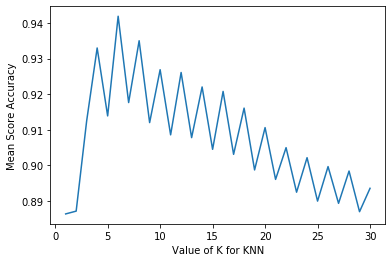

In [21]:
#plt.plot(k_range, )
score = pd.DataFrame(grid.cv_results_)['mean_test_score']
plt.plot(k_range, score)
plt.xlabel('Value of K for KNN')
plt.ylabel('Mean Score Accuracy')

In [37]:
knn  = KNeighborsClassifier(n_neighbors = 4, weights = 'uniform')
knn.fit(X, y)

df_arrest_test = pd.DataFrame.sample(df_arrest, frac = .01, random_state = 3412)

X = df_arrest_test #data
y = df_arrest_test['IsMale'] #target

#knn.predict(df_arrest_test)

Multiple parameter grid search

passes dict of possible variables to run function (knn), can add more? limited value depending on the type of analysis being performed

In [23]:
#multi parameter grid search

k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']

param_grid = dict(n_neighbors = k_range, weights = weight_options)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance']}


In [38]:
%%time
grid = GridSearchCV(knn, param_grid, cv = 10, scoring = 'accuracy', return_train_score = False)
grid.fit(X, y)
results = pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
results

Wall time: 4min 19s


,mean_test_score,std_test_score,params
0,0.89,0.01,"{'n_neighbors': 1, 'weights': 'uniform'}"
1,0.89,0.01,"{'n_neighbors': 1, 'weights': 'distance'}"
2,0.89,0.01,"{'n_neighbors': 2, 'weights': 'uniform'}"
3,0.89,0.01,"{'n_neighbors': 2, 'weights': 'distance'}"
4,0.91,0.01,"{'n_neighbors': 3, 'weights': 'uniform'}"
5,0.91,0.01,"{'n_neighbors': 3, 'weights': 'distance'}"
6,0.93,0.01,"{'n_neighbors': 4, 'weights': 'uniform'}"
7,0.92,0.01,"{'n_neighbors': 4, 'weights': 'distance'}"
8,0.91,0.01,"{'n_neighbors': 5, 'weights': 'uniform'}"
9,0.91,0.01,"{'n_neighbors': 5, 'weights': 'distance'}"


No handles with labels found to put in legend.


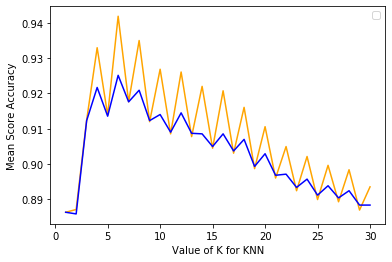

In [56]:

#score_dist = pd.DataFrame(grid.cv_results_)['mean_test_score']

weight_u = pd.DataFrame(grid.cv_results_)[pd.DataFrame(grid.cv_results_)['param_weights'] == 'uniform']#results from uniform parameter weights
weight_d = pd.DataFrame(grid.cv_results_)[pd.DataFrame(grid.cv_results_)['param_weights'] == 'distance']

plt.plot(k_range, weight_u['mean_test_score'], color = 'orange')
plt.plot(k_range, weight_d['mean_test_score'], color = 'blue')
plt.xlabel('Value of K for KNN')
plt.ylabel('Mean Score Accuracy')
plt.legend()

In [59]:
%%time 
from sklearn.model_selection import RandomizedSearchCV

k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']

param_dist = dict(n_neighbors = k_range, weights = weight_options)

df_arrest_test = pd.DataFrame.sample(df_arrest, frac = .005, random_state = 3412)

X = df_arrest_test #data
y = df_arrest_test['IsMale'] #target


rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5, return_train_score=False)
rand.fit(X, y)

pd.DataFrame(rand.cv_results_)[['mean_test_score', 'std_test_score', 'params']]


Wall time: 1h 15min 58s


,mean_test_score,std_test_score,params
0,0.94,0.00,"{'weights': 'distance', 'n_neighbors': 16}"
1,0.94,0.00,"{'weights': 'uniform', 'n_neighbors': 22}"
2,0.94,0.00,"{'weights': 'uniform', 'n_neighbors': 18}"
3,0.93,0.00,"{'weights': 'uniform', 'n_neighbors': 27}"
4,0.93,0.00,"{'weights': 'uniform', 'n_neighbors': 29}"
5,0.94,0.00,"{'weights': 'distance', 'n_neighbors': 10}"
6,0.93,0.00,"{'weights': 'distance', 'n_neighbors': 22}"
7,0.95,0.00,"{'weights': 'uniform', 'n_neighbors': 14}"
8,0.94,0.00,"{'weights': 'distance', 'n_neighbors': 12}"
9,0.93,0.00,"{'weights': 'uniform', 'n_neighbors': 15}"


In [62]:
%%time 
from sklearn.model_selection import RandomizedSearchCV

k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']

param_dist = dict(n_neighbors = k_range, weights = weight_options)

df_arrest_test = pd.DataFrame.sample(df_arrest, frac = .005, random_state = 3412)

X = df_arrest_test #data
y = df_arrest_test['age_range'] #target


rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5, return_train_score=False)
rand.fit(X, y)

pd.DataFrame(rand.cv_results_)[['mean_test_score', 'std_test_score', 'params']]


Wall time: 43.8 s


,mean_test_score,std_test_score,params
0,0.97,0.00,"{'weights': 'distance', 'n_neighbors': 16}"
1,0.97,0.00,"{'weights': 'uniform', 'n_neighbors': 22}"
2,0.97,0.01,"{'weights': 'uniform', 'n_neighbors': 18}"
3,0.98,0.00,"{'weights': 'uniform', 'n_neighbors': 27}"
4,0.98,0.01,"{'weights': 'uniform', 'n_neighbors': 29}"
5,0.96,0.01,"{'weights': 'distance', 'n_neighbors': 10}"
6,0.98,0.00,"{'weights': 'distance', 'n_neighbors': 22}"
7,0.97,0.01,"{'weights': 'uniform', 'n_neighbors': 14}"
8,0.96,0.00,"{'weights': 'distance', 'n_neighbors': 12}"
9,0.97,0.01,"{'weights': 'uniform', 'n_neighbors': 15}"


In [61]:
df_arrest_test.columns

Index(['Arrest Type Code', 'age_range', 'IsMale', 'DOW_Monday', 'DOW_Saturday',
       'DOW_Sunday', 'DOW_Thursday', 'DOW_Tuesday', 'DOW_Wednesday', 'Area_10',
       'Area_11', 'Area_12', 'Area_13', 'Area_14', 'Area_15', 'Area_16',
       'Area_17', 'Area_18', 'Area_19', 'Area_2', 'Area_20', 'Area_21',
       'Area_3', 'Area_4', 'Area_5', 'Area_6', 'Area_7', 'Area_8', 'Area_9',
       'Charge_10.0', 'Charge_11.0', 'Charge_12.0', 'Charge_13.0',
       'Charge_14.0', 'Charge_15.0', 'Charge_16.0', 'Charge_17.0',
       'Charge_18.0', 'Charge_19.0', 'Charge_2.0', 'Charge_20.0',
       'Charge_21.0', 'Charge_22.0', 'Charge_23.0', 'Charge_24.0',
       'Charge_25.0', 'Charge_27.0', 'Charge_29.0', 'Charge_3.0', 'Charge_4.0',
       'Charge_5.0', 'Charge_6.0', 'Charge_7.0', 'Charge_8.0', 'Charge_9.0',
       'Charge_99.0', 'Charge_nan', 'Hour_1', 'Hour_10', 'Hour_11', 'Hour_12',
       'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18',
       'Hour_19', 'Hour_2', 'Hour_20', 'Ho